In [9]:
# tuning notebook template for jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [10]:
# DEV LOCAL: Approach to download the input dataset to dev on my local computer
# the TS examples does not have MIST, which I need to download manually and store under ./data/img_align_celeba/
# from tensorflow.examples.tutorials.mnist import input_data
# mnist_images = input_data.read_data_sets('MNIST_data')

In [11]:
# data_dir = './data'
# data_dir = './MNIST_data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

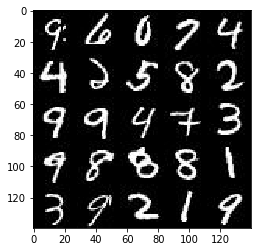

In [12]:
import helper
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

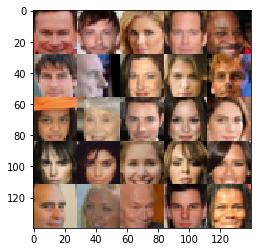

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function

    real_dim = (image_width, image_height, image_channels)
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    
    alpha = 0.1

    with tf.variable_scope('discriminator', reuse=reuse):
        
        layer_1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu_1 = tf.maximum(alpha * layer_1, layer_1)
        # 14x14x128; 5
        
        layer_2 = tf.layers.conv2d(relu_1, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_2 = tf.layers.batch_normalization(layer_2, training=True)
        relu_2 = tf.maximum(alpha * bn_2, bn_2)
        # 7x7x256; 5
        
        layer_3 = tf.layers.conv2d(relu_2, 512, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_3 = tf.layers.batch_normalization(layer_3, training=True)
        relu_3 = tf.maximum(alpha * bn_3, bn_3)
        # 4x4x512; 5
        
        layer_4 = tf.layers.conv2d(relu_3, 512, 2, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_4 = tf.layers.batch_normalization(layer_4, training=True)
        relu_4 = tf.maximum(alpha * bn_4, bn_4)
        # 4x4x512
        
        flattened = tf.reshape(relu_4, (-1, 4*4*512))
        # 1x8192
        
        # tensor output of the discriminator
        logits = tf.layers.dense(flattened, 1)
        
        # tensor logits of the discriminator)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        layer_1 = tf.layers.dense(z, 7*7*512)
        layer_1 = tf.reshape(layer_1, (-1, 7, 7, 512))
        bn_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        relu_1 = tf.maximum(alpha * bn_1, bn_1)
        # 7x7x512
        
        layer_2 = tf.layers.conv2d_transpose(relu_1, 256, 2, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        relu_2 = tf.maximum(alpha * bn_2, bn_2)
        # 14x14x256
        
        layer_3 = tf.layers.conv2d_transpose(relu_2, 128, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_3 = tf.layers.batch_normalization(layer_3, training=is_train)
        relu_3 = tf.maximum(alpha * bn_3, bn_3)
        # 28x28x128
        
        layer_4 = tf.layers.conv2d_transpose(relu_3, 64, 4, strides=1, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn_4 = tf.layers.batch_normalization(layer_4, training=is_train)
        relu_4 = tf.maximum(alpha * bn_4, bn_4)
        
        logits = tf.layers.conv2d_transpose(relu_4, out_channel_dim, 4, strides=1, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Tensor output
        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # DONE: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Modeltrain
    
    # DEV: printing call arameters
    print("Parameters are epoch_count(%s), batch_size(%s), z_dim(%s), learning_rate(%s), beta1(%s), data_shape(%s), data_image_mode(%s)" 
          % (epoch_count, batch_size, z_dim, learning_rate, beta1, data_shape, data_image_mode))
    
    # loging settings
    print_step_module = 25
    print_sample_module = 100
    
    # Model inputs
    # print(data_shape[1])
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Model losses
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Model optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # DONE: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Generator random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               lr: learning_rate})
                
                if steps % print_step_module == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}: Step {}...".format(epoch_i+1, steps+1),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % print_sample_module == 0:
                    show_generator_output(sess, 36, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Parameters are epoch_count(2), batch_size(32), z_dim(100), learning_rate(0.0003), beta1(0.5), data_shape((60000, 28, 28, 1)), data_image_mode(L)
Epoch 1: Step 26... Discriminator Loss: 2.9979... Generator Loss: 0.1369
Epoch 1: Step 51... Discriminator Loss: 4.8133... Generator Loss: 0.0137
Epoch 1: Step 76... Discriminator Loss: 2.4414... Generator Loss: 0.1371
Epoch 1: Step 101... Discriminator Loss: 1.4187... Generator Loss: 0.9699


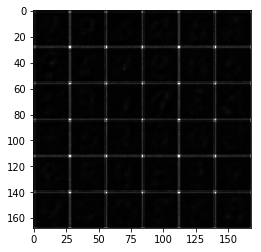

Epoch 1: Step 126... Discriminator Loss: 1.1690... Generator Loss: 0.6231
Epoch 1: Step 151... Discriminator Loss: 1.6089... Generator Loss: 0.2978
Epoch 1: Step 176... Discriminator Loss: 2.8387... Generator Loss: 0.0892
Epoch 1: Step 201... Discriminator Loss: 2.0097... Generator Loss: 0.2128


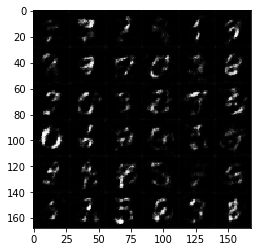

Epoch 1: Step 226... Discriminator Loss: 2.0231... Generator Loss: 0.2559
Epoch 1: Step 251... Discriminator Loss: 1.3688... Generator Loss: 0.5039
Epoch 1: Step 276... Discriminator Loss: 0.9648... Generator Loss: 1.3869
Epoch 1: Step 301... Discriminator Loss: 1.2351... Generator Loss: 2.7821


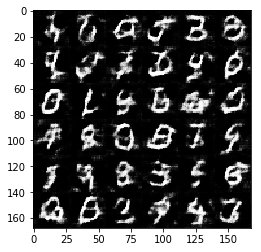

Epoch 1: Step 326... Discriminator Loss: 1.3981... Generator Loss: 0.6691
Epoch 1: Step 351... Discriminator Loss: 1.8244... Generator Loss: 0.2794
Epoch 1: Step 376... Discriminator Loss: 2.6871... Generator Loss: 0.0924
Epoch 1: Step 401... Discriminator Loss: 1.5225... Generator Loss: 0.3632


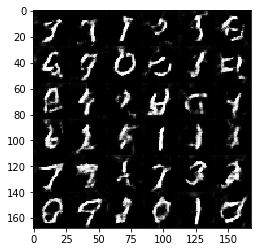

Epoch 1: Step 426... Discriminator Loss: 0.7399... Generator Loss: 1.0629
Epoch 1: Step 451... Discriminator Loss: 0.6791... Generator Loss: 1.5906
Epoch 1: Step 476... Discriminator Loss: 1.4935... Generator Loss: 0.4579
Epoch 1: Step 501... Discriminator Loss: 1.4384... Generator Loss: 0.3541


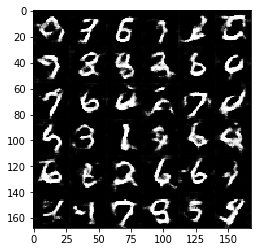

Epoch 1: Step 526... Discriminator Loss: 1.5676... Generator Loss: 0.4103
Epoch 1: Step 551... Discriminator Loss: 2.1812... Generator Loss: 0.2056
Epoch 1: Step 576... Discriminator Loss: 2.3819... Generator Loss: 0.1160
Epoch 1: Step 601... Discriminator Loss: 0.7034... Generator Loss: 0.9718


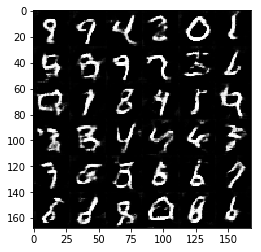

Epoch 1: Step 626... Discriminator Loss: 0.7564... Generator Loss: 0.7539
Epoch 1: Step 651... Discriminator Loss: 1.3704... Generator Loss: 0.3642
Epoch 1: Step 676... Discriminator Loss: 0.7662... Generator Loss: 0.8816
Epoch 1: Step 701... Discriminator Loss: 1.8279... Generator Loss: 0.3094


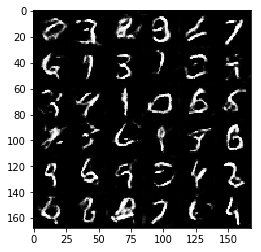

Epoch 1: Step 726... Discriminator Loss: 0.8919... Generator Loss: 0.6040
Epoch 1: Step 751... Discriminator Loss: 2.5416... Generator Loss: 0.1160
Epoch 1: Step 776... Discriminator Loss: 3.4387... Generator Loss: 0.0411
Epoch 1: Step 801... Discriminator Loss: 1.4628... Generator Loss: 0.4278


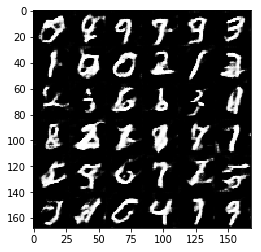

Epoch 1: Step 826... Discriminator Loss: 0.9602... Generator Loss: 0.6966
Epoch 1: Step 851... Discriminator Loss: 2.8087... Generator Loss: 0.0700
Epoch 1: Step 876... Discriminator Loss: 1.1052... Generator Loss: 0.5974
Epoch 1: Step 901... Discriminator Loss: 1.4759... Generator Loss: 0.3059


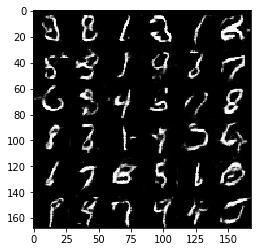

Epoch 1: Step 926... Discriminator Loss: 1.3369... Generator Loss: 0.4042
Epoch 1: Step 951... Discriminator Loss: 0.8467... Generator Loss: 1.1467
Epoch 1: Step 976... Discriminator Loss: 0.7001... Generator Loss: 0.9091
Epoch 1: Step 1001... Discriminator Loss: 1.2493... Generator Loss: 3.7513


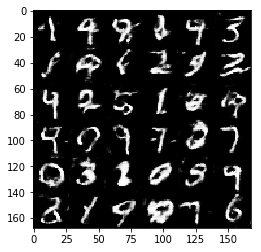

Epoch 1: Step 1026... Discriminator Loss: 1.7593... Generator Loss: 0.3711
Epoch 1: Step 1051... Discriminator Loss: 1.4563... Generator Loss: 0.3891
Epoch 1: Step 1076... Discriminator Loss: 1.4978... Generator Loss: 0.3742
Epoch 1: Step 1101... Discriminator Loss: 2.0545... Generator Loss: 0.2155


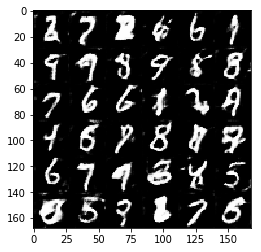

Epoch 1: Step 1126... Discriminator Loss: 0.3319... Generator Loss: 2.1310
Epoch 1: Step 1151... Discriminator Loss: 1.1674... Generator Loss: 0.4883
Epoch 1: Step 1176... Discriminator Loss: 1.9661... Generator Loss: 0.2550
Epoch 1: Step 1201... Discriminator Loss: 1.7818... Generator Loss: 0.3609


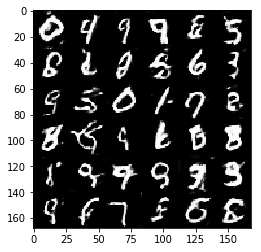

Epoch 1: Step 1226... Discriminator Loss: 0.8172... Generator Loss: 0.8277
Epoch 1: Step 1251... Discriminator Loss: 0.6185... Generator Loss: 1.1624
Epoch 1: Step 1276... Discriminator Loss: 0.7600... Generator Loss: 0.8350
Epoch 1: Step 1301... Discriminator Loss: 1.1999... Generator Loss: 0.7045


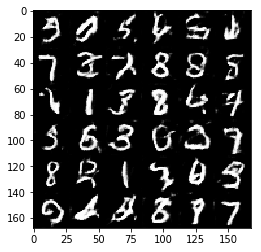

Epoch 1: Step 1326... Discriminator Loss: 1.1635... Generator Loss: 0.8050
Epoch 1: Step 1351... Discriminator Loss: 1.7560... Generator Loss: 0.2614
Epoch 1: Step 1376... Discriminator Loss: 0.6313... Generator Loss: 1.1484
Epoch 1: Step 1401... Discriminator Loss: 1.0755... Generator Loss: 0.5509


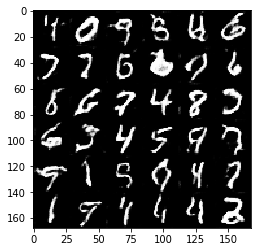

Epoch 1: Step 1426... Discriminator Loss: 1.5244... Generator Loss: 0.4840
Epoch 1: Step 1451... Discriminator Loss: 0.7310... Generator Loss: 2.3172
Epoch 1: Step 1476... Discriminator Loss: 1.0926... Generator Loss: 2.4019
Epoch 1: Step 1501... Discriminator Loss: 0.7363... Generator Loss: 0.9336


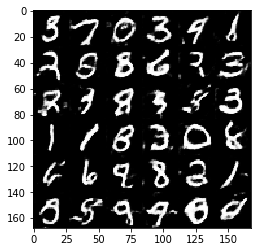

Epoch 1: Step 1526... Discriminator Loss: 1.3091... Generator Loss: 0.4085
Epoch 1: Step 1551... Discriminator Loss: 0.6965... Generator Loss: 0.7643
Epoch 1: Step 1576... Discriminator Loss: 1.8742... Generator Loss: 0.2325
Epoch 1: Step 1601... Discriminator Loss: 2.0015... Generator Loss: 0.2368


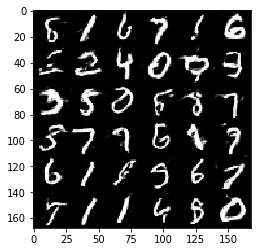

Epoch 1: Step 1626... Discriminator Loss: 1.2342... Generator Loss: 0.5326
Epoch 1: Step 1651... Discriminator Loss: 1.3205... Generator Loss: 0.6271
Epoch 1: Step 1676... Discriminator Loss: 1.3602... Generator Loss: 0.3492
Epoch 1: Step 1701... Discriminator Loss: 0.5813... Generator Loss: 1.4882


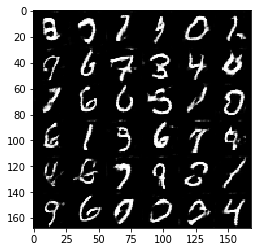

Epoch 1: Step 1726... Discriminator Loss: 1.2017... Generator Loss: 0.5251
Epoch 1: Step 1751... Discriminator Loss: 0.9471... Generator Loss: 0.7390
Epoch 1: Step 1776... Discriminator Loss: 2.8888... Generator Loss: 0.1355
Epoch 1: Step 1801... Discriminator Loss: 0.7257... Generator Loss: 2.1351


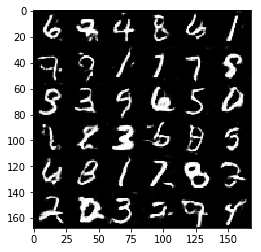

Epoch 1: Step 1826... Discriminator Loss: 0.7917... Generator Loss: 0.8098
Epoch 1: Step 1851... Discriminator Loss: 0.6119... Generator Loss: 1.4207
Epoch 1: Step 1876... Discriminator Loss: 1.9598... Generator Loss: 0.1796
Epoch 2: Step 1901... Discriminator Loss: 1.8606... Generator Loss: 0.2675


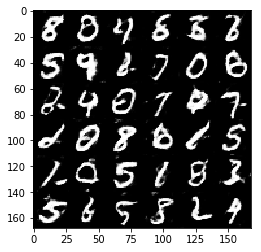

Epoch 2: Step 1926... Discriminator Loss: 1.1789... Generator Loss: 0.6406
Epoch 2: Step 1951... Discriminator Loss: 0.5164... Generator Loss: 2.1762
Epoch 2: Step 1976... Discriminator Loss: 1.8137... Generator Loss: 0.3207
Epoch 2: Step 2001... Discriminator Loss: 1.3589... Generator Loss: 0.4256


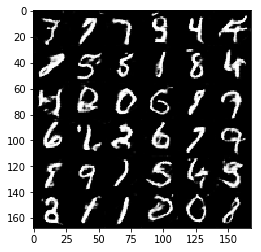

Epoch 2: Step 2026... Discriminator Loss: 1.8649... Generator Loss: 0.6002
Epoch 2: Step 2051... Discriminator Loss: 3.1397... Generator Loss: 0.0669
Epoch 2: Step 2076... Discriminator Loss: 0.9870... Generator Loss: 0.6826
Epoch 2: Step 2101... Discriminator Loss: 1.4453... Generator Loss: 0.3128


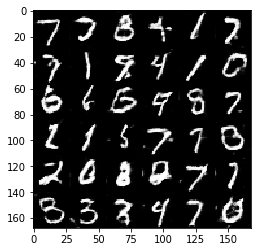

Epoch 2: Step 2126... Discriminator Loss: 1.7976... Generator Loss: 0.3387
Epoch 2: Step 2151... Discriminator Loss: 2.1239... Generator Loss: 0.1489
Epoch 2: Step 2176... Discriminator Loss: 1.8853... Generator Loss: 0.3030
Epoch 2: Step 2201... Discriminator Loss: 0.5297... Generator Loss: 1.6832


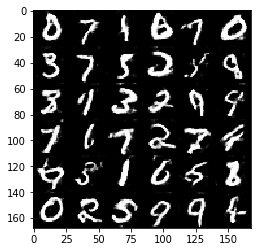

Epoch 2: Step 2226... Discriminator Loss: 1.1413... Generator Loss: 0.4646
Epoch 2: Step 2251... Discriminator Loss: 1.9711... Generator Loss: 0.1818
Epoch 2: Step 2276... Discriminator Loss: 2.3676... Generator Loss: 0.1391
Epoch 2: Step 2301... Discriminator Loss: 1.8956... Generator Loss: 0.1908


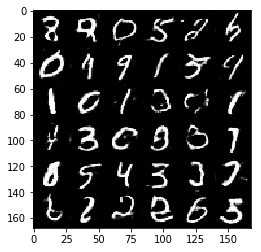

Epoch 2: Step 2326... Discriminator Loss: 0.9193... Generator Loss: 0.6646
Epoch 2: Step 2351... Discriminator Loss: 1.5449... Generator Loss: 0.2592
Epoch 2: Step 2376... Discriminator Loss: 1.8520... Generator Loss: 0.2151
Epoch 2: Step 2401... Discriminator Loss: 2.0914... Generator Loss: 0.1724


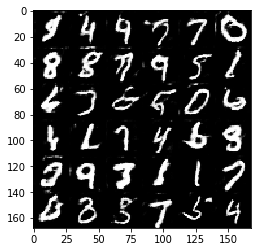

Epoch 2: Step 2426... Discriminator Loss: 1.7090... Generator Loss: 0.2363
Epoch 2: Step 2451... Discriminator Loss: 1.1632... Generator Loss: 0.8658
Epoch 2: Step 2476... Discriminator Loss: 0.9665... Generator Loss: 0.6995
Epoch 2: Step 2501... Discriminator Loss: 0.8766... Generator Loss: 0.6729


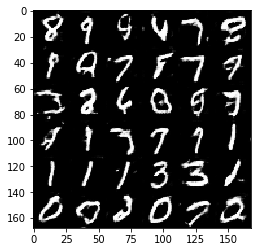

Epoch 2: Step 2526... Discriminator Loss: 0.8527... Generator Loss: 0.9691
Epoch 2: Step 2551... Discriminator Loss: 0.7314... Generator Loss: 0.9687
Epoch 2: Step 2576... Discriminator Loss: 1.2921... Generator Loss: 0.6396
Epoch 2: Step 2601... Discriminator Loss: 1.5646... Generator Loss: 0.2968


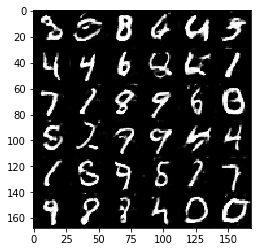

Epoch 2: Step 2626... Discriminator Loss: 0.8588... Generator Loss: 0.6106
Epoch 2: Step 2651... Discriminator Loss: 1.6593... Generator Loss: 0.4407
Epoch 2: Step 2676... Discriminator Loss: 0.5870... Generator Loss: 1.1325
Epoch 2: Step 2701... Discriminator Loss: 1.1711... Generator Loss: 0.5133


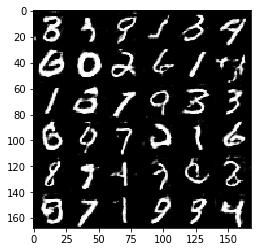

Epoch 2: Step 2726... Discriminator Loss: 3.7698... Generator Loss: 0.0255
Epoch 2: Step 2751... Discriminator Loss: 0.3307... Generator Loss: 2.1609
Epoch 2: Step 2776... Discriminator Loss: 0.4801... Generator Loss: 2.3562
Epoch 2: Step 2801... Discriminator Loss: 2.5234... Generator Loss: 0.1375


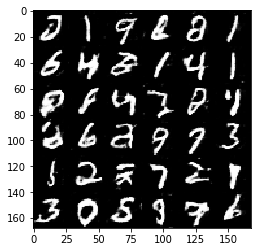

Epoch 2: Step 2826... Discriminator Loss: 1.1870... Generator Loss: 0.5399
Epoch 2: Step 2851... Discriminator Loss: 1.0013... Generator Loss: 0.5518
Epoch 2: Step 2876... Discriminator Loss: 1.0801... Generator Loss: 0.5125
Epoch 2: Step 2901... Discriminator Loss: 1.3111... Generator Loss: 0.4681


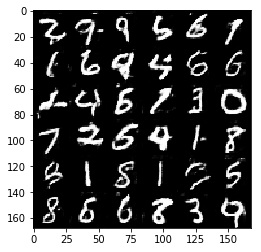

Epoch 2: Step 2926... Discriminator Loss: 0.8774... Generator Loss: 0.6210
Epoch 2: Step 2951... Discriminator Loss: 1.8328... Generator Loss: 0.2227
Epoch 2: Step 2976... Discriminator Loss: 1.0076... Generator Loss: 0.6086
Epoch 2: Step 3001... Discriminator Loss: 2.1294... Generator Loss: 0.2539


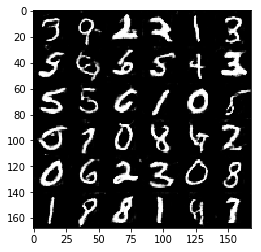

Epoch 2: Step 3026... Discriminator Loss: 1.4159... Generator Loss: 0.4506
Epoch 2: Step 3051... Discriminator Loss: 1.3162... Generator Loss: 0.8243
Epoch 2: Step 3076... Discriminator Loss: 1.2825... Generator Loss: 0.5094
Epoch 2: Step 3101... Discriminator Loss: 1.6646... Generator Loss: 0.2474


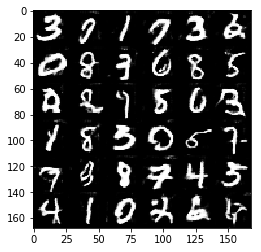

Epoch 2: Step 3126... Discriminator Loss: 2.0267... Generator Loss: 0.2057
Epoch 2: Step 3151... Discriminator Loss: 1.0068... Generator Loss: 0.6367
Epoch 2: Step 3176... Discriminator Loss: 0.9183... Generator Loss: 0.6076
Epoch 2: Step 3201... Discriminator Loss: 1.1327... Generator Loss: 0.6709


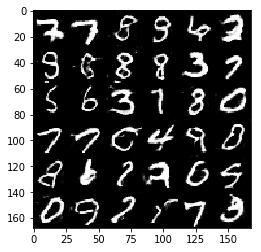

Epoch 2: Step 3226... Discriminator Loss: 1.2953... Generator Loss: 0.4446
Epoch 2: Step 3251... Discriminator Loss: 0.6181... Generator Loss: 1.5295
Epoch 2: Step 3276... Discriminator Loss: 1.9502... Generator Loss: 0.2349
Epoch 2: Step 3301... Discriminator Loss: 0.8368... Generator Loss: 1.0842


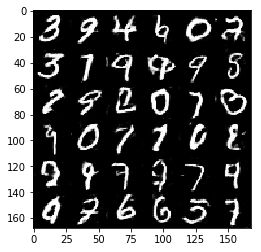

Epoch 2: Step 3326... Discriminator Loss: 1.7750... Generator Loss: 0.3016
Epoch 2: Step 3351... Discriminator Loss: 2.4278... Generator Loss: 0.2479
Epoch 2: Step 3376... Discriminator Loss: 2.2242... Generator Loss: 0.1464
Epoch 2: Step 3401... Discriminator Loss: 2.6405... Generator Loss: 0.1395


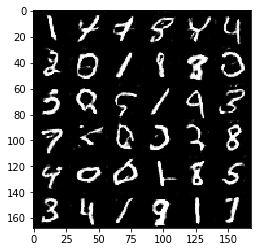

Epoch 2: Step 3426... Discriminator Loss: 1.5160... Generator Loss: 0.3042
Epoch 2: Step 3451... Discriminator Loss: 0.9984... Generator Loss: 0.9576
Epoch 2: Step 3476... Discriminator Loss: 1.1852... Generator Loss: 0.4419
Epoch 2: Step 3501... Discriminator Loss: 1.5667... Generator Loss: 0.3821


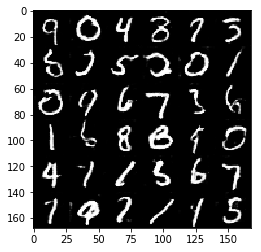

Epoch 2: Step 3526... Discriminator Loss: 1.4020... Generator Loss: 0.4653
Epoch 2: Step 3551... Discriminator Loss: 1.4189... Generator Loss: 0.4030
Epoch 2: Step 3576... Discriminator Loss: 2.0760... Generator Loss: 0.1738
Epoch 2: Step 3601... Discriminator Loss: 2.3388... Generator Loss: 0.2549


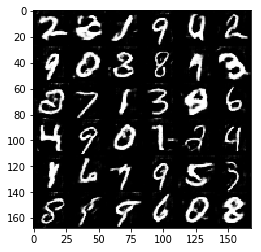

Epoch 2: Step 3626... Discriminator Loss: 1.8368... Generator Loss: 0.2743
Epoch 2: Step 3651... Discriminator Loss: 1.2547... Generator Loss: 0.3897
Epoch 2: Step 3676... Discriminator Loss: 1.5645... Generator Loss: 0.3599
Epoch 2: Step 3701... Discriminator Loss: 1.8864... Generator Loss: 0.2239


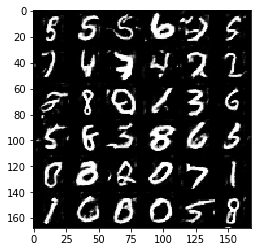

Epoch 2: Step 3726... Discriminator Loss: 2.2634... Generator Loss: 0.1144
Epoch 2: Step 3751... Discriminator Loss: 2.1383... Generator Loss: 0.2050


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Parameters are epoch_count(4), batch_size(64), z_dim(100), learning_rate(0.0003), beta1(0.5), data_shape((202599, 28, 28, 3)), data_image_mode(RGB)
Epoch 1: Step 26... Discriminator Loss: 1.0489... Generator Loss: 0.7743
Epoch 1: Step 51... Discriminator Loss: 0.2409... Generator Loss: 2.1089
Epoch 1: Step 76... Discriminator Loss: 0.4244... Generator Loss: 1.3317
Epoch 1: Step 101... Discriminator Loss: 0.3554... Generator Loss: 1.9652


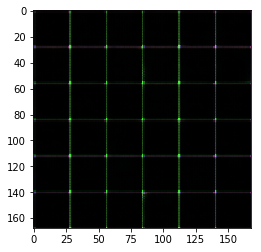

Epoch 1: Step 126... Discriminator Loss: 2.2720... Generator Loss: 6.2611
Epoch 1: Step 151... Discriminator Loss: 0.4449... Generator Loss: 1.4738
Epoch 1: Step 176... Discriminator Loss: 1.4859... Generator Loss: 0.4300
Epoch 1: Step 201... Discriminator Loss: 1.3257... Generator Loss: 0.4979


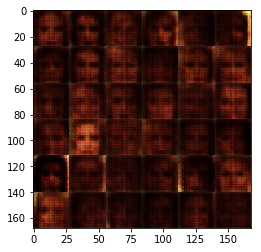

Epoch 1: Step 226... Discriminator Loss: 0.3521... Generator Loss: 2.3050
Epoch 1: Step 251... Discriminator Loss: 0.8844... Generator Loss: 0.9092
Epoch 1: Step 276... Discriminator Loss: 0.2824... Generator Loss: 2.4345
Epoch 1: Step 301... Discriminator Loss: 0.5320... Generator Loss: 1.8175


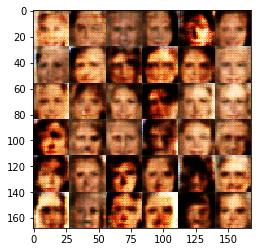

Epoch 1: Step 326... Discriminator Loss: 1.8551... Generator Loss: 0.2308
Epoch 1: Step 351... Discriminator Loss: 2.9213... Generator Loss: 4.7388
Epoch 1: Step 376... Discriminator Loss: 0.6864... Generator Loss: 1.2701
Epoch 1: Step 401... Discriminator Loss: 2.7176... Generator Loss: 4.8427


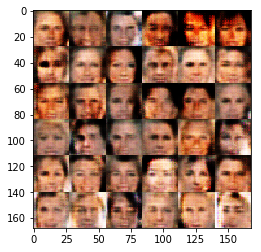

Epoch 1: Step 426... Discriminator Loss: 0.5161... Generator Loss: 3.3723
Epoch 1: Step 451... Discriminator Loss: 2.8405... Generator Loss: 3.5691
Epoch 1: Step 476... Discriminator Loss: 0.9023... Generator Loss: 1.5910
Epoch 1: Step 501... Discriminator Loss: 0.6494... Generator Loss: 1.5289


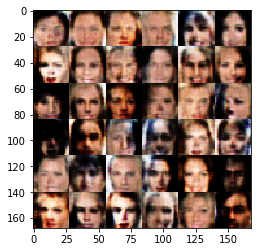

Epoch 1: Step 526... Discriminator Loss: 0.3650... Generator Loss: 1.6233
Epoch 1: Step 551... Discriminator Loss: 1.5388... Generator Loss: 0.3087
Epoch 1: Step 576... Discriminator Loss: 0.8424... Generator Loss: 0.9018
Epoch 1: Step 601... Discriminator Loss: 0.5736... Generator Loss: 0.9877


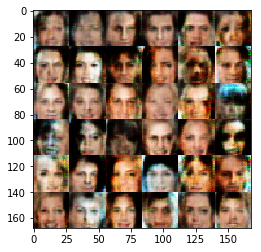

Epoch 1: Step 626... Discriminator Loss: 0.3825... Generator Loss: 1.5476
Epoch 1: Step 651... Discriminator Loss: 1.1005... Generator Loss: 0.5410
Epoch 1: Step 676... Discriminator Loss: 1.1250... Generator Loss: 0.7047
Epoch 1: Step 701... Discriminator Loss: 0.4973... Generator Loss: 3.0594


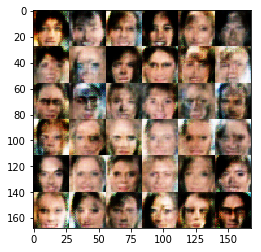

Epoch 1: Step 726... Discriminator Loss: 1.4332... Generator Loss: 4.3806
Epoch 1: Step 751... Discriminator Loss: 2.8121... Generator Loss: 0.0917
Epoch 1: Step 776... Discriminator Loss: 1.3337... Generator Loss: 0.3777
Epoch 1: Step 801... Discriminator Loss: 1.1704... Generator Loss: 0.5005


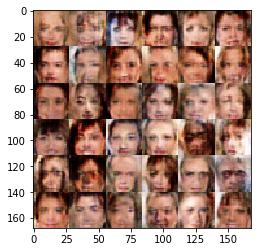

Epoch 1: Step 826... Discriminator Loss: 0.4581... Generator Loss: 1.3725
Epoch 1: Step 851... Discriminator Loss: 1.5226... Generator Loss: 0.3754
Epoch 1: Step 876... Discriminator Loss: 0.7804... Generator Loss: 2.8935
Epoch 1: Step 901... Discriminator Loss: 1.2927... Generator Loss: 0.4272


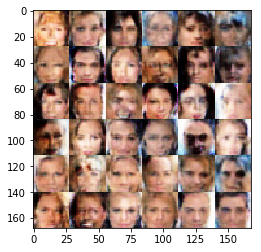

Epoch 1: Step 926... Discriminator Loss: 0.1450... Generator Loss: 2.8963
Epoch 1: Step 951... Discriminator Loss: 0.9131... Generator Loss: 0.6729
Epoch 1: Step 976... Discriminator Loss: 1.2583... Generator Loss: 0.4801
Epoch 1: Step 1001... Discriminator Loss: 1.2683... Generator Loss: 2.4828


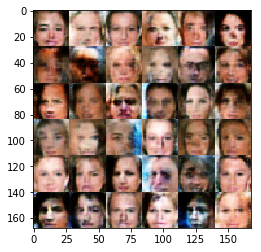

Epoch 1: Step 1026... Discriminator Loss: 0.7415... Generator Loss: 0.8506
Epoch 1: Step 1051... Discriminator Loss: 1.2871... Generator Loss: 0.3996
Epoch 1: Step 1076... Discriminator Loss: 0.8284... Generator Loss: 0.7469
Epoch 1: Step 1101... Discriminator Loss: 0.7940... Generator Loss: 1.3401


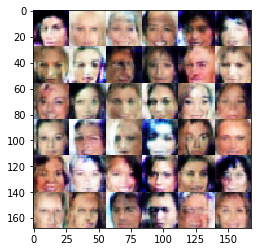

Epoch 1: Step 1126... Discriminator Loss: 1.2474... Generator Loss: 0.5426
Epoch 1: Step 1151... Discriminator Loss: 0.7068... Generator Loss: 1.3207
Epoch 1: Step 1176... Discriminator Loss: 1.0925... Generator Loss: 0.7071
Epoch 1: Step 1201... Discriminator Loss: 0.7477... Generator Loss: 0.9517


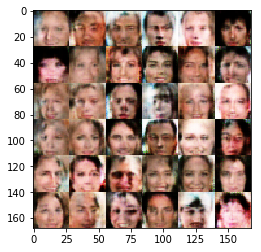

Epoch 1: Step 1226... Discriminator Loss: 1.4479... Generator Loss: 0.3257
Epoch 1: Step 1251... Discriminator Loss: 1.2550... Generator Loss: 0.4852
Epoch 1: Step 1276... Discriminator Loss: 1.9285... Generator Loss: 0.2760
Epoch 1: Step 1301... Discriminator Loss: 1.0890... Generator Loss: 1.7456


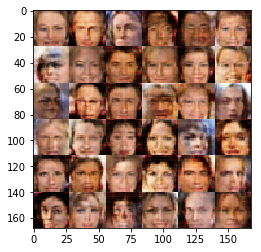

Epoch 1: Step 1326... Discriminator Loss: 0.6993... Generator Loss: 0.9583
Epoch 1: Step 1351... Discriminator Loss: 0.9896... Generator Loss: 0.6854
Epoch 1: Step 1376... Discriminator Loss: 1.1076... Generator Loss: 0.5143
Epoch 1: Step 1401... Discriminator Loss: 0.7302... Generator Loss: 1.9712


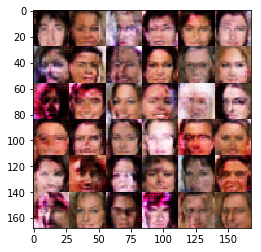

Epoch 1: Step 1426... Discriminator Loss: 1.4602... Generator Loss: 2.4628
Epoch 1: Step 1451... Discriminator Loss: 0.4596... Generator Loss: 3.1460
Epoch 1: Step 1476... Discriminator Loss: 1.2235... Generator Loss: 2.6994
Epoch 1: Step 1501... Discriminator Loss: 1.5111... Generator Loss: 0.3020


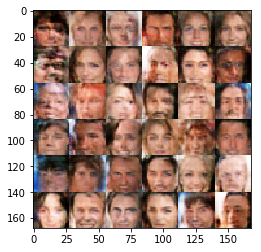

Epoch 1: Step 1526... Discriminator Loss: 1.4476... Generator Loss: 0.3245
Epoch 1: Step 1551... Discriminator Loss: 0.3906... Generator Loss: 1.5273
Epoch 1: Step 1576... Discriminator Loss: 1.4172... Generator Loss: 0.3540
Epoch 1: Step 1601... Discriminator Loss: 0.8541... Generator Loss: 1.3276


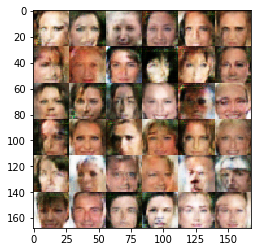

Epoch 1: Step 1626... Discriminator Loss: 0.7345... Generator Loss: 0.8388
Epoch 1: Step 1651... Discriminator Loss: 1.0763... Generator Loss: 0.5527
Epoch 1: Step 1676... Discriminator Loss: 1.7358... Generator Loss: 0.2304
Epoch 1: Step 1701... Discriminator Loss: 0.7334... Generator Loss: 1.0152


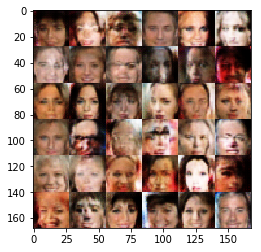

Epoch 1: Step 1726... Discriminator Loss: 1.4700... Generator Loss: 0.3785
Epoch 1: Step 1751... Discriminator Loss: 2.1682... Generator Loss: 0.1457
Epoch 1: Step 1776... Discriminator Loss: 0.5486... Generator Loss: 1.6554
Epoch 1: Step 1801... Discriminator Loss: 1.7463... Generator Loss: 0.3465


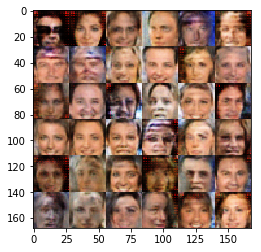

Epoch 1: Step 1826... Discriminator Loss: 0.3103... Generator Loss: 1.7666
Epoch 1: Step 1851... Discriminator Loss: 0.6372... Generator Loss: 2.4307


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.